In [1]:
import pandas as pd

# Path to the CSV file
df_fullset_path = "df_raw_clean.csv"

# Read the CSV file
df_fullset = pd.read_csv(df_fullset_path)
df_fullset= df_fullset.drop(['body_cleaned', 'submission_cleaned'], axis=1)

In [2]:
# Convert 'timestamp' to datetime format
df_fullset['timestamp'] = pd.to_datetime(df_fullset['timestamp'], errors='coerce')
df_fullset['date'] = pd.to_datetime(df_fullset['date'], errors='coerce')

# Convert 'date' from UTC to GMT+8
df_fullset['timestamp'] = df_fullset['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Etc/GMT-8')
df_fullset = df_fullset.dropna(subset=['timestamp', 'date'])

In [3]:
#drop the rows where author name is missing from the data
df_fullset.dropna(inplace=True)

In [4]:
# Create 'hour' column from 'datetime' column
df_fullset['hour'] = df_fullset['timestamp'].dt.hour
df_fullset = df_fullset.sort_values('hour')
df_fullset['hour'] = df_fullset['timestamp'].dt.strftime('%I%p')

# Insert 'hour' column at the 4th position
df_fullset.insert(3, 'hour', df_fullset.pop('hour'))

In [5]:
#filter out all rows with the dates between 2024-03-11 and 2024-03-14

# Define the date range
start_date = '2024-03-11'
end_date = '2024-03-14'

# Filter out rows within the date range
df_modelling = df_fullset[(df_fullset['date'] >= start_date) & (df_fullset['date'] <= end_date)]

In [6]:
# Calculate the number of samples per group
n = 2000
weights = n * df_modelling['sub_reddit'].value_counts() / len(df_modelling)

# Sample the DataFrame
df_sample = df_modelling.groupby('sub_reddit').apply(lambda x: x.sample(int(weights[x.name]), replace=True)).reset_index(drop=True)


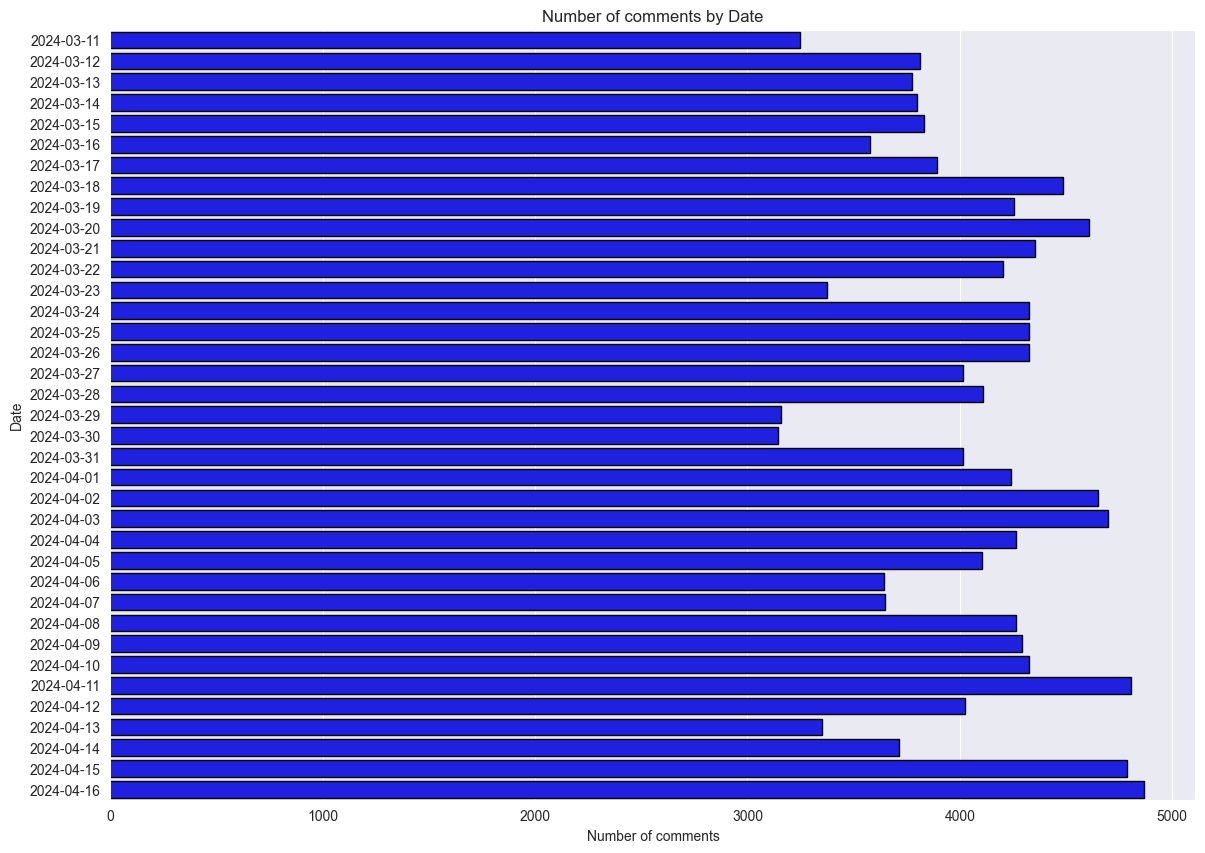

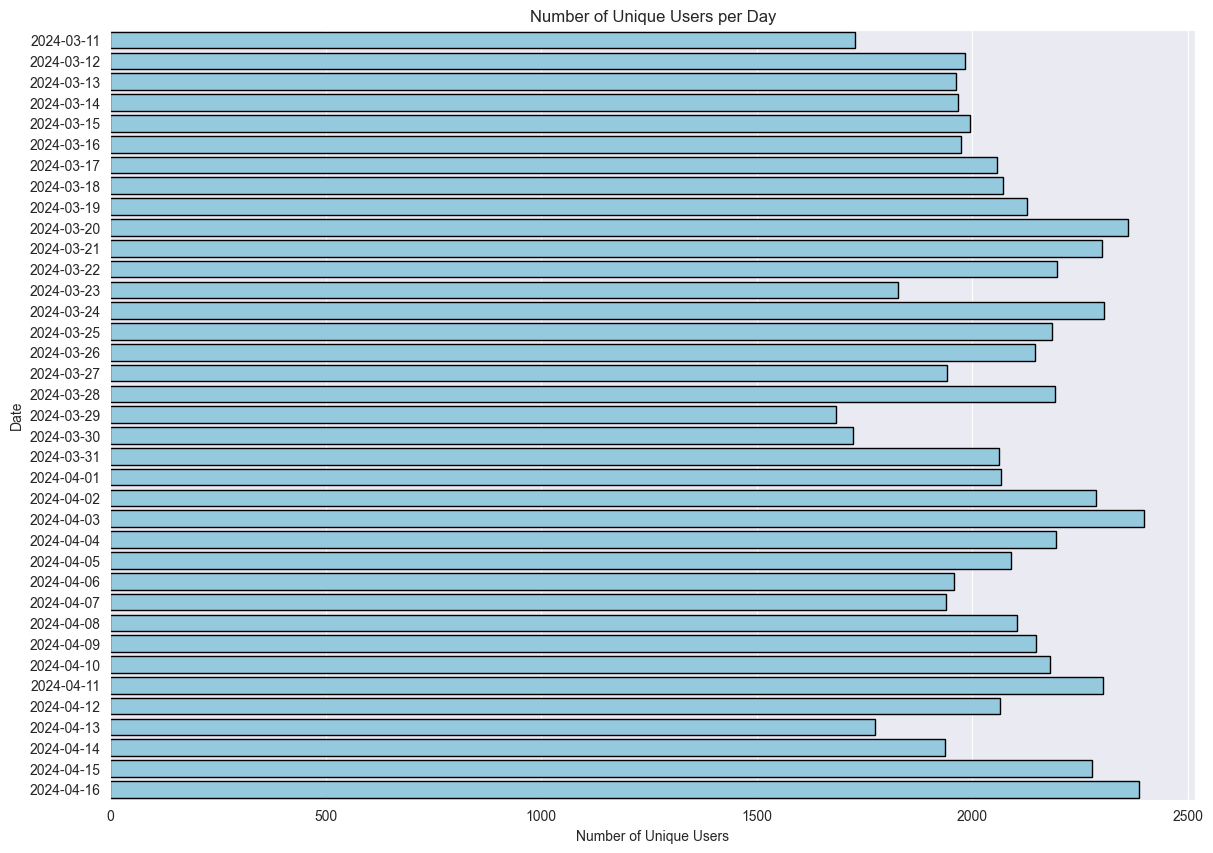

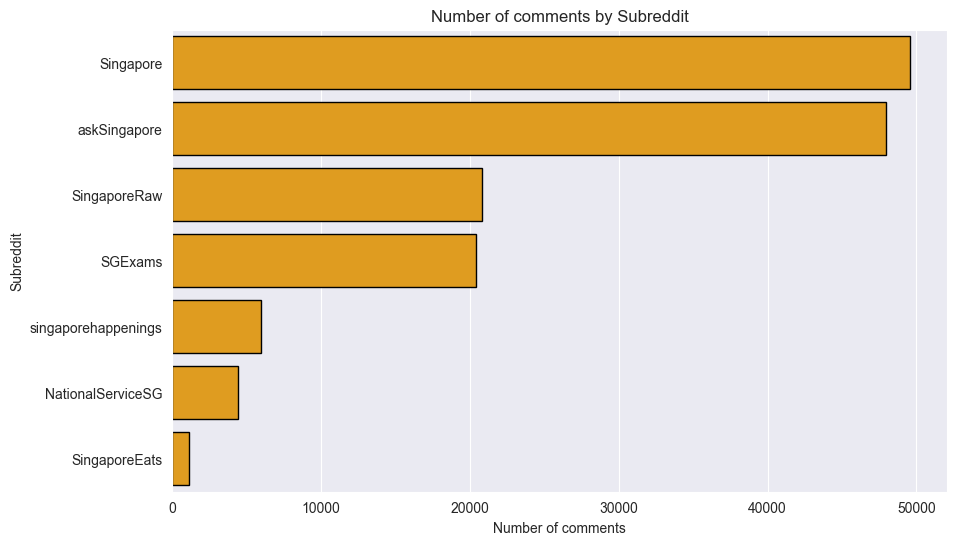

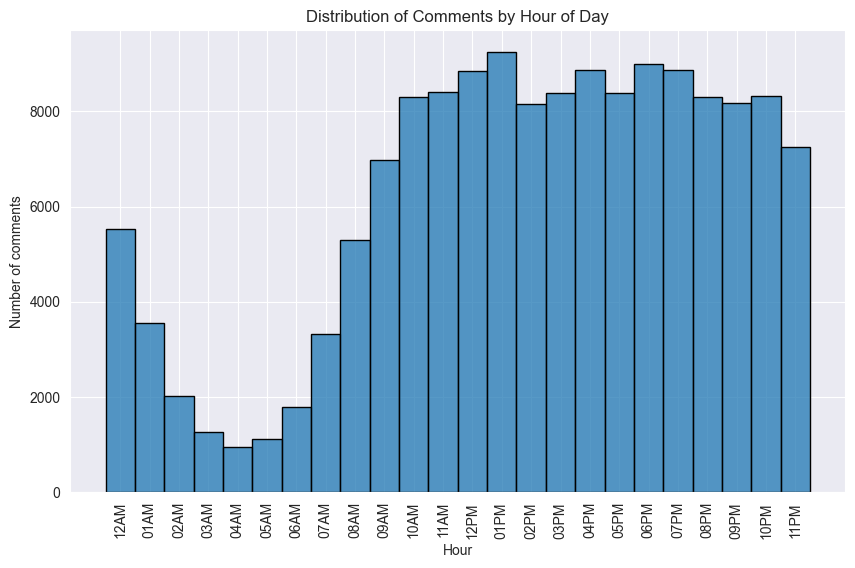

In [7]:
# EDA for original full dataset

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


# Get the date frequencies
date_counts = df_fullset['date'].dt.date.value_counts().sort_index()

# Convert date_counts to DataFrame
date_counts_df = date_counts.reset_index()
date_counts_df.columns = ['Date', 'Frequency']

plt.figure(figsize=(14, 10))
sns.barplot(data=date_counts_df, y='Date', x='Frequency', color='blue',edgecolor='black')
plt.title('Number of comments by Date')
plt.xlabel('Number of comments')
plt.ylabel('Date')
plt.show()

user_unique_per_day = df_fullset.groupby(df_fullset['date'].dt.date)['author'].nunique().reset_index()
# Plot the number of unique users against days
plt.figure(figsize=(14, 10))
sns.barplot(data=user_unique_per_day, y='date', x='author', color='skyblue', edgecolor='black')
plt.title('Number of Unique Users per Day')
plt.ylabel('Date')
plt.xlabel('Number of Unique Users')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df_fullset, y='sub_reddit', order=df_fullset['sub_reddit'].value_counts().index, color='orange',edgecolor='black')
plt.title('Number of comments by Subreddit')
plt.xlabel('Number of comments')
plt.ylabel('Subreddit')
plt.show()


# Create a histogram for the 'hour' column
plt.figure(figsize=(10, 6))
sns.histplot(df_fullset['hour'], bins=24, kde=False, edgecolor='black')
plt.title('Distribution of Comments by Hour of Day')
plt.xlabel('Hour')
plt.xticks(rotation=90)
plt.ylabel('Number of comments')
plt.show()

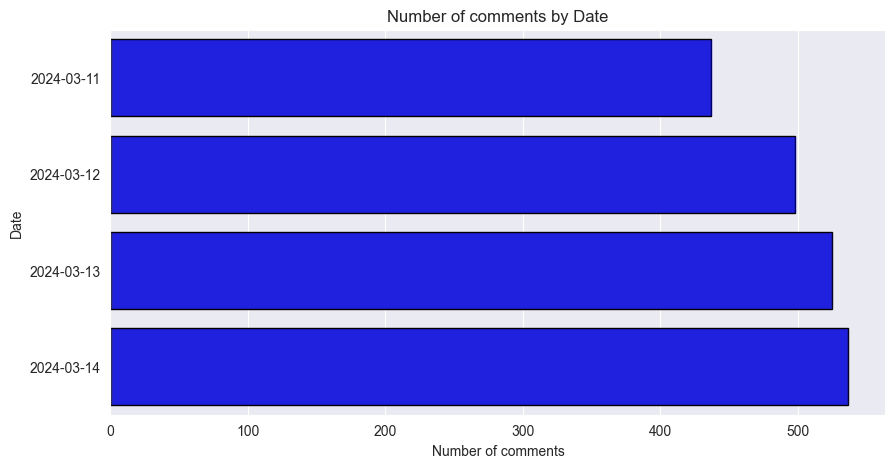

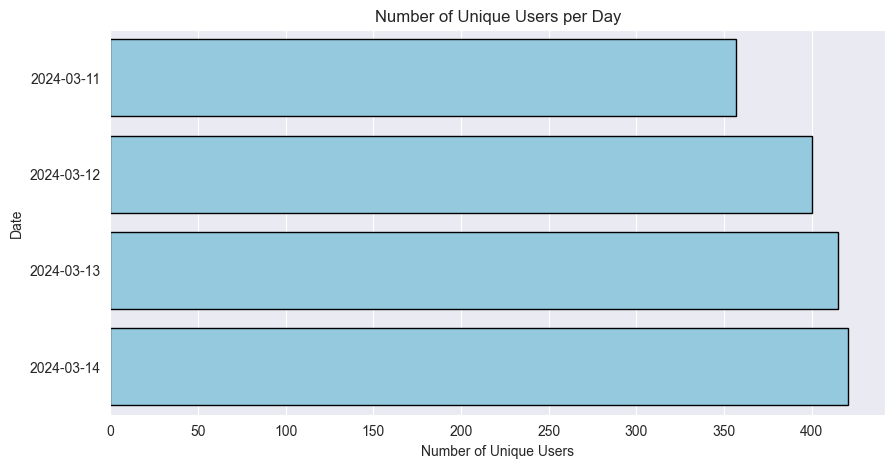

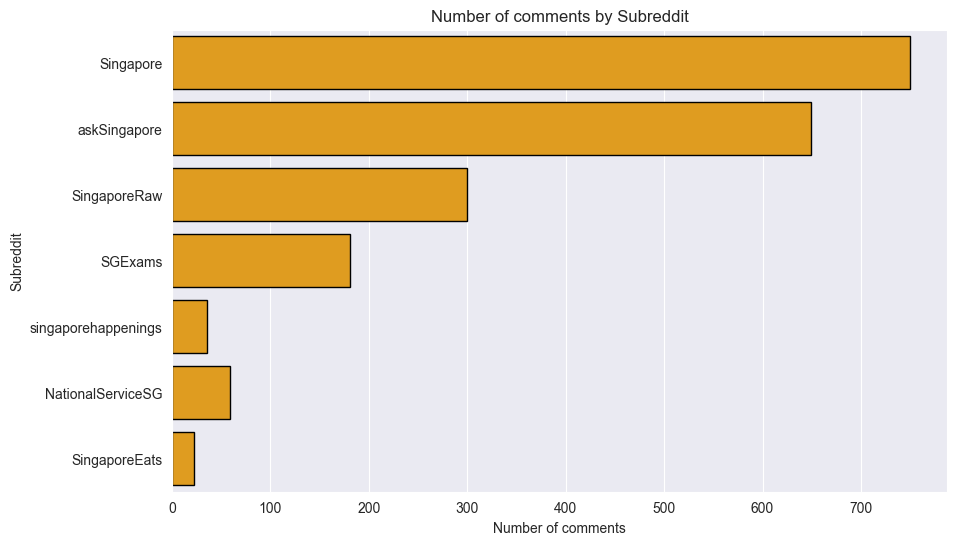

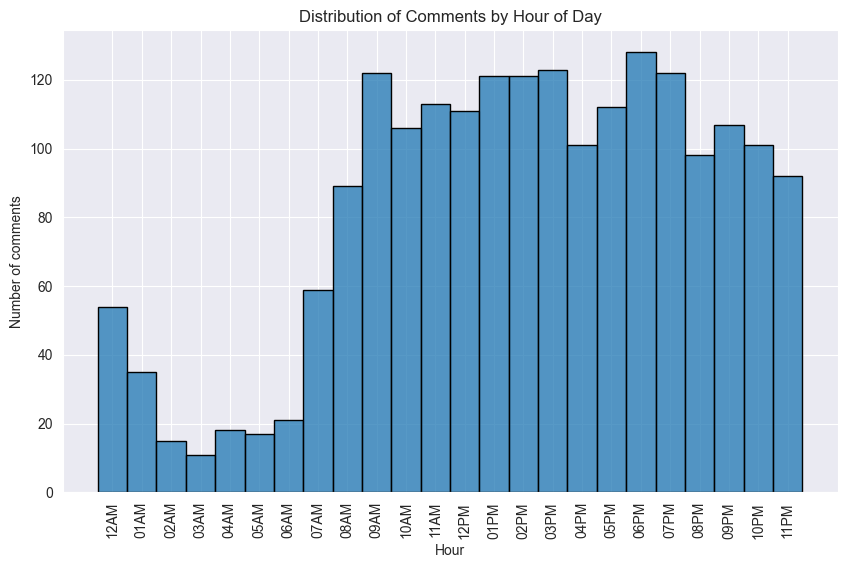

In [8]:
# EDA for df_sample rows:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Get the date frequencies
date_counts = df_sample['date'].dt.date.value_counts().sort_index()

# Convert date_counts to DataFrame
date_counts_df = date_counts.reset_index()
date_counts_df.columns = ['Date', 'Frequency']

plt.figure(figsize=(10, 5))
sns.barplot(data=date_counts_df, y='Date', x='Frequency', color='blue',edgecolor='black')
plt.title('Number of comments by Date')
plt.xlabel('Number of comments')
plt.ylabel('Date')
plt.show()

user_unique_per_day = df_sample.groupby(df_sample['date'].dt.date)['author'].nunique().reset_index()

# Plot the number of unique users against days
plt.figure(figsize=(10, 5))
sns.barplot(data=user_unique_per_day, y='date', x='author', color='skyblue', edgecolor='black')
plt.title('Number of Unique Users per Day')
plt.ylabel('Date')
plt.xlabel('Number of Unique Users')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df_sample, y='sub_reddit', order=df_fullset['sub_reddit'].value_counts().index, color='orange',edgecolor='black')
plt.title('Number of comments by Subreddit')
plt.xlabel('Number of comments')
plt.ylabel('Subreddit')
plt.show()

df_sample['hour'] = df_sample['timestamp'].dt.strftime('%H')
df_sample = df_sample.sort_values('hour')
df_sample['hour'] = df_sample['timestamp'].dt.strftime('%I%p')
plt.figure(figsize=(10, 6))
sns.histplot(df_sample['hour'], bins=24, kde=False, edgecolor='black')
plt.title('Distribution of Comments by Hour of Day')
plt.xlabel('Hour')
plt.xticks(rotation=90)
plt.ylabel('Number of comments')
plt.show()

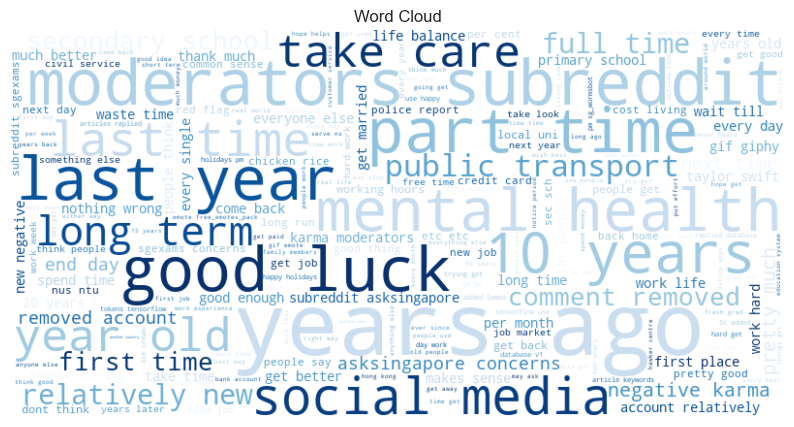

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize

add_stopwords_list = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 
                     'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 
                     'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
                     'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
                     'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 
                     'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 
                     'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 
                     'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 
                     'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 
                     'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 
                     'now', "i'll", "you'll", "he'll", "she'll", "we'll", "they'll", "i'd", "you'd", "he'd", "she'd", 
                     "we'd", "they'd", "i'm", "you're", "he's", "she's", "it's", "we're", "they're", "i've", "we've", 
                     "you've", "they've", "isn't", "aren't", "wasn't", "weren't", "haven't", "hasn't", "hadn't", "don't", 
                     "doesn't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "mustn't", "can't", "couldn't", 
                     'cannot', 'could', "here's", "how's", "let's", 'ought', "that's", "there's", "what's", "when's", 
                     "where's", "who's", "why's", 'would', 'i', 'we', 'he', 'she', 'is', 'like', 'and', 'the',
                    'want','really','u','go','s','still','sounds','like','make','sure','feel','maybe','need',
                     'bot', 'action','performed', 'automatically','please', 'contact','message','compose','questions',
                     'even','though','many','one','someone','people''get','also','us','might','let','know']
# Get the stopwords list
stopwords_list = stopwords.words('english') + add_stopwords_list
# Remove http tags
df_fullset['body'] = df_fullset['body'].replace(r'http\S+', '', regex=True)

# Convert to lowercase
df_fullset['body'] = df_fullset['body'].str.lower()

# Remove punctuation
df_fullset['body'] = df_fullset['body'].str.replace('[^\w\s]', '')

# Remove stopwords
df_fullset['body'] = df_fullset['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords_list)
bigram_counts = vectorizer.fit_transform(df_fullset['body'])
feature_names = vectorizer.get_feature_names_out()
bigram_freq = dict(zip(feature_names, bigram_counts.sum(axis=0).tolist()[0]))

# Create WordCloud from the bigram frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='Blues').generate_from_frequencies(bigram_freq)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis('off')
plt.show()

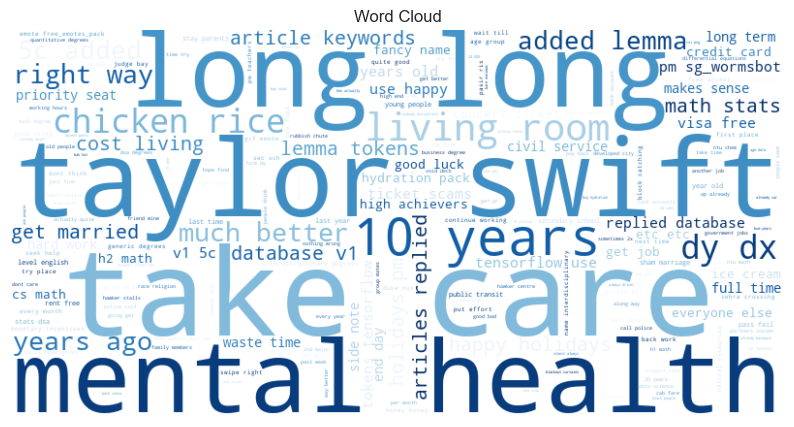

In [10]:
# Remove http tags
df_sample['body'] = df_sample['body'].replace(r'http\S+', '', regex=True)

# Convert to lowercase
df_sample['body'] = df_sample['body'].str.lower()

# Remove punctuation
df_sample['body'] = df_sample['body'].str.replace('[^\w\s]', '')

# Remove stopwords
df_sample['body'] = df_sample['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=stopwords_list)
bigram_counts = vectorizer.fit_transform(df_sample['body'])
feature_names = vectorizer.get_feature_names_out()
bigram_freq = dict(zip(feature_names, bigram_counts.sum(axis=0).tolist()[0]))

# Create WordCloud from the bigram frequencies
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='Blues').generate_from_frequencies(bigram_freq)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis('off')
plt.show()